In [1]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
import xgboost as xgb
import operator
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
FOLDS = 4
N_JOBS = 6
SEED = 2016
TEST_SPLIT = 0.2

#DATA = "Base"
#DATA = "Lags"
#DATA = "Time"
DATA = "April"


C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Get data
train1 = pd.read_csv("clean_data/train1_" + DATA + ".csv")
train2 = pd.read_csv("clean_data/train2_" + DATA + ".csv")
train3 = pd.read_csv("clean_data/train3_" + DATA + ".csv")
train4 = pd.read_csv("clean_data/train4_" + DATA + ".csv")
train5 = pd.read_csv("clean_data/train5_" + DATA + ".csv")
test = pd.read_csv("clean_data/test_" + DATA + ".csv")
y_1 = pd.read_csv("clean_data/y_1.csv")
y_2 = pd.read_csv("clean_data/y_2.csv")
y_3 = pd.read_csv("clean_data/y_3.csv")
y_4 = pd.read_csv("clean_data/y_4.csv")
y_5 = pd.read_csv("clean_data/y_5.csv")

test_ids = test.Id

print(train1.shape)
print(y_1.shape)
print(train2.shape)
print(y_2.shape)
print(train3.shape)
print(y_3.shape)
print(train4.shape)
print(y_4.shape)
print(train5.shape)
print(y_5.shape)

# Split data for final performance check
X_train1, X_test1, y_train1, y_test1 = train_test_split(train1, y_1, test_size = TEST_SPLIT, random_state = SEED)
X_train2, X_test2, y_train2, y_test2 = train_test_split(train2, y_2, test_size = TEST_SPLIT, random_state = SEED)
X_train3, X_test3, y_train3, y_test3 = train_test_split(train3, y_3, test_size = TEST_SPLIT, random_state = SEED)
X_train4, X_test4, y_train4, y_test4 = train_test_split(train4, y_4, test_size = TEST_SPLIT, random_state = SEED)
X_train5, X_test5, y_train5, y_test5 = train_test_split(train5, y_5, test_size = TEST_SPLIT, random_state = SEED)

y_test1.Id_bat = X_test1.Id_bat
y_test2.Id_bat = X_test2.Id_bat
y_test3.Id_bat = X_test3.Id_bat
y_test4.Id_bat = X_test4.Id_bat
y_test5.Id_bat = X_test5.Id_bat

# Save y_test for later ensembling
name1 = "clean_data/y_test1.csv"
name2 = "clean_data/y_test2.csv"
name3 = "clean_data/y_test3.csv"
name4 = "clean_data/y_test4.csv"
name5 = "clean_data/y_test5.csv"

pd.DataFrame({"Id": y_test1.Id, "Id_bat": y_test1.Id_bat, "y1": y_test1.y1}, columns = ["Id", "Id_bat", "y1"]).to_csv(name1, index = None)
pd.DataFrame({"Id": y_test2.Id, "Id_bat": y_test2.Id_bat, "y2": y_test2.y2}, columns = ["Id", "Id_bat", "y2"]).to_csv(name2, index = None)
pd.DataFrame({"Id": y_test3.Id, "Id_bat": y_test3.Id_bat, "y3": y_test3.y3}, columns = ["Id", "Id_bat", "y3"]).to_csv(name3, index = None)
pd.DataFrame({"Id": y_test4.Id, "Id_bat": y_test4.Id_bat, "y4": y_test4.y4}, columns = ["Id", "Id_bat", "y4"]).to_csv(name4, index = None)
pd.DataFrame({"Id": y_test5.Id, "Id_bat": y_test5.Id_bat, "y5": y_test5.y5}, columns = ["Id", "Id_bat", "y5"]).to_csv(name5, index = None)


(2976, 8)
(2976, 2)
(2232, 8)
(2232, 2)
(744, 8)
(744, 2)
(2232, 8)
(2232, 2)
(2976, 8)
(2976, 2)


In [3]:
# Definitions for XGBoost

xg_params = {
    "booster" : "gbtree", 
    "eta" : 0.1,
    "max_depth" : 12,
    "min_child_weight" : 2,
    "subsample" : 0.7,
    "colsample_bytree" : 0.7,
    "objective" : "reg:linear",
}

def xgb_mse(preds, dtrain) :
    labels = dtrain.get_label()
    return ("mse", mean_squared_error(preds, labels))

def run_xgb(X_train, y_train) : 
    xg_train = xgb.DMatrix(X_train, label = y_train)    

    res = xgb.cv(xg_params, 
                 xg_train, 
                 num_boost_round = 100000, 
                 nfold = FOLDS, 
                 seed = SEED, 
                 stratified = False,
                 early_stopping_rounds = 100, 
                 verbose_eval = False, 
                 feval = xgb_mse, 
                 maximize = False)

    best_nrounds = res.shape[0] - 1
    cv_mean = res.iloc[-1, 0]
    print("CV-Mean : " + str(cv_mean))
    
    xg = xgb.train(xg_params, xg_train, best_nrounds)
    
    print("XGBOOST best_iteration " + str(xg.best_iteration))
    return (xg)


In [4]:
# Generate y_test predictions to be able to optimize ensemble weights
xg_test1 = xgb.DMatrix(X_test1)
xg_test2 = xgb.DMatrix(X_test2)
xg_test3 = xgb.DMatrix(X_test3)
xg_test4 = xgb.DMatrix(X_test4)
xg_test5 = xgb.DMatrix(X_test5)

print("y1 : ")   
xg = run_xgb(X_train1, y_train1.y1)
preds_y_test1 = xg.predict(xg_test1)    
print("-----")

print("y2 : ")    
xg = run_xgb(X_train2, y_train2.y2)
preds_y_test2 = xg.predict(xg_test2)    
print("-----")
    
print("y3 : ")    
xg = run_xgb(X_train3, y_train3.y3)
preds_y_test3 = xg.predict(xg_test3)    
print("-----")
    
print("y4 : ")    
xg = run_xgb(X_train4, y_train4.y4)
preds_y_test4 = xg.predict(xg_test4)    
print("-----")
    
print("y5 : ")    
xg = run_xgb(X_train5, y_train5.y5)
preds_y_test5 = xg.predict(xg_test5)    
print("-----")


y1 : 
CV-Mean : 130.3524305
XGBOOST best_iteration 326
-----
y2 : 
CV-Mean : 714.5638885
XGBOOST best_iteration 442
-----
y3 : 
CV-Mean : 45.3970155
XGBOOST best_iteration 69
-----
y4 : 
CV-Mean : 622.48531325
XGBOOST best_iteration 71
-----
y5 : 
CV-Mean : 2110.17324825
XGBOOST best_iteration 43
-----


In [5]:
# Show MSE on y_test
print("Average XGB MSE on held-out fold for y1 : " + str(mean_squared_error(y_test1.y1, preds_y_test1)))
print("Average XGB MSE on held-out fold for y2 : " + str(mean_squared_error(y_test2.y2, preds_y_test2)))
print("Average XGB MSE on held-out fold for y3 : " + str(mean_squared_error(y_test3.y3, preds_y_test3)))
print("Average XGB MSE on held-out fold for y4 : " + str(mean_squared_error(y_test4.y4, preds_y_test4)))
print("Average XGB MSE on held-out fold for y5 : " + str(mean_squared_error(y_test5.y5, preds_y_test5)))


Average XGB MSE on held-out fold for y1 : 101.347419115
Average XGB MSE on held-out fold for y2 : 663.701524625
Average XGB MSE on held-out fold for y3 : 42.147641363
Average XGB MSE on held-out fold for y4 : 666.780808285
Average XGB MSE on held-out fold for y5 : 2480.44444412


In [6]:
# Generate test predictions to be able to optimize ensemble weights
print("DATA : " + DATA)
xg_test = xgb.DMatrix(test)

print("y1 : ")   
xg = run_xgb(train1, y_1.y1)
preds_test1 = xg.predict(xg_test)    
print("-----")

print("y2 : ")    
xg = run_xgb(train2, y_2.y2)
preds_test2 = xg.predict(xg_test)    
print("-----")
    
print("y3 : ")    
xg = run_xgb(train3, y_3.y3)
preds_test3 = xg.predict(xg_test)    
print("-----")
    
print("y4 : ")    
xg = run_xgb(train4, y_4.y4)
preds_test4 = xg.predict(xg_test)    
print("-----")
    
print("y5 : ")    
xg = run_xgb(train5, y_5.y5)
preds_test5 = xg.predict(xg_test)    
print("-----")


DATA : April
y1 : 
CV-Mean : 100.848755
XGBOOST best_iteration 269
-----
y2 : 
CV-Mean : 632.46783425
XGBOOST best_iteration 424
-----
y3 : 
CV-Mean : 45.10623075
XGBOOST best_iteration 48
-----
y4 : 
CV-Mean : 533.50810225
XGBOOST best_iteration 136
-----
y5 : 
CV-Mean : 2147.599182
XGBOOST best_iteration 44
-----


In [7]:
# Correct predictions for special outputs
preds_test2[test[test.Id_bat == 3].index] = 0
preds_test3[test[test.Id_bat != 3].index] = 0
preds_test4[test[test.Id_bat == 3].index] = 0

In [8]:
# Save predictions
y_test_name1 = "y_test_preds/XGBalt1_" + DATA + ".csv"
y_test_name2 = "y_test_preds/XGBalt2_" + DATA + ".csv"
y_test_name3 = "y_test_preds/XGBalt3_" + DATA + ".csv"
y_test_name4 = "y_test_preds/XGBalt4_" + DATA + ".csv"
y_test_name5 = "y_test_preds/XGBalt5_" + DATA + ".csv"
test_name = "test_preds/XGBalt_" + DATA + ".csv"
pd.DataFrame({"Id": y_test1.Id, "y1": preds_y_test1}, columns = ["Id", "y1"]).to_csv(y_test_name1, index = None, sep = ";")
pd.DataFrame({"Id": y_test2.Id, "y2": preds_y_test2}, columns = ["Id", "y2"]).to_csv(y_test_name2, index = None, sep = ";")
pd.DataFrame({"Id": y_test3.Id, "y3": preds_y_test3}, columns = ["Id", "y3"]).to_csv(y_test_name3, index = None, sep = ";")
pd.DataFrame({"Id": y_test4.Id, "y4": preds_y_test4}, columns = ["Id", "y4"]).to_csv(y_test_name4, index = None, sep = ";")
pd.DataFrame({"Id": y_test5.Id, "y5": preds_y_test5}, columns = ["Id", "y5"]).to_csv(y_test_name5, index = None, sep = ";")
pd.DataFrame({"Id": test.Id, "y1": preds_test1, "y2": preds_test2, "y3": preds_test3, "y4": preds_test4, "y5": preds_test5}, 
             columns = ["Id", "y1", "y2", "y3", "y4", "y5"]).to_csv(test_name, index = None, sep = ";")

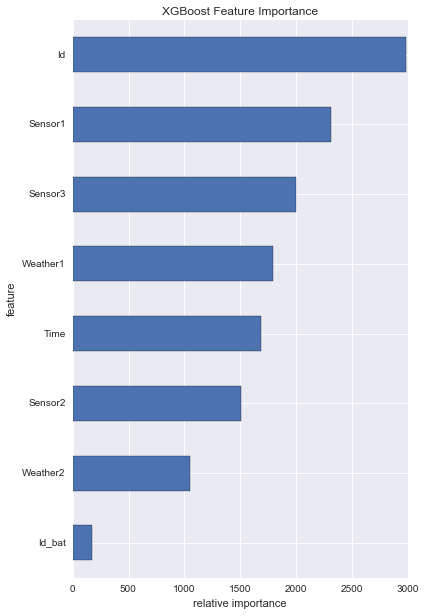

In [9]:
# Visualize most important features
importance = xg.get_fscore()
importance = sorted(importance.items(), key = operator.itemgetter(1))
df = pd.DataFrame(importance, columns=["feature", "fscore"])
g = df.tail(30).plot(kind = "barh", x = "feature", y = "fscore", legend = False, figsize = (6, 10))
plt.title("XGBoost Feature Importance")
plt.xlabel("relative importance")
plt.show()